In [1]:
import numpy as np
import torch
import pyro
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints
from pyro import distributions as dst
from collections import defaultdict
import matplotlib.pylab as plt

In [2]:
pyro.enable_validation(True)

In [12]:
N = 1000
D = 2
K = 2

In [13]:
hyperparameters = (torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D)),torch.abs(torch.randn(K)))

In [14]:
def dgp(X, hyperparameters):
    N, D = X.shape
    K = 2
    coord_scale_loc, coord_scale_scale, loc_loc, loc_scale, component_logits_concentration = hyperparameters
    with pyro.plate('D', D):
        coord_scale = pyro.sample('coord_scale', dst.LogNormal(coord_scale_loc,coord_scale_scale))
        with pyro.plate('K', K):
            locs = pyro.sample('loc', dst.Normal(loc_loc, loc_scale))
    component_logits = pyro.sample('component_logits', dst.Dirichlet(component_logits_concentration))
    with pyro.plate('N', N):
        X = pyro.sample('obs', dst.MixtureOfDiagNormalsSharedCovariance(locs = locs, coord_scale = coord_scale, component_logits = component_logits))
    return X

In [24]:
trace = pyro.poutine.trace(dgp).get_trace(torch.zeros(N,D), hyperparameters)
logp = trace.log_prob_sum()
true_variables = [trace.nodes[name]["value"] for name in trace.stochastic_nodes]
trace.stochastic_nodes

['D', 'coord_scale', 'K', 'loc', 'component_logits', 'N', 'obs']

In [25]:
logp

tensor(103.4392)

In [26]:
_,true_loc,true_scale,_,true_cov_factor,_,data = true_variables

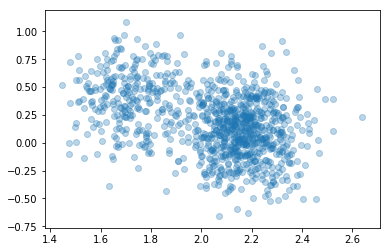

In [27]:
plt.scatter(*data.detach().numpy().T,alpha=.3)

In [50]:
def model(X, hyperparameters):
    N, D = X.shape
    K = 2
    coord_scale_loc, coord_scale_scale, loc_loc, loc_scale, component_logits_concentration = hyperparameters
    with pyro.plate('D', D):
        coord_scale = pyro.sample('coord_scale', dst.LogNormal(coord_scale_loc,coord_scale_scale))
        with pyro.plate('K', K):
            locs = pyro.sample('locs', dst.Normal(loc_loc, loc_scale))
    component_logits = pyro.sample('component_logits', dst.Dirichlet(component_logits_concentration))
    with pyro.plate('N', N):
        X = pyro.sample('obs', dst.MixtureOfDiagNormalsSharedCovariance(locs = locs, coord_scale = coord_scale, component_logits = component_logits))
    return X

In [51]:
def guide(X, hyperparameters):
    N, D = X.shape
    K = 2
    coord_scale_loc, coord_scale_scale, loc_loc, loc_scale, component_logits_concentration = hyperparameters
    with pyro.plate('D', D):
        coord_scale_loc = pyro.param('coord_scale_loc', coord_scale_loc)
        coord_scale_scale = pyro.param('coord_scale_scale', coord_scale_scale, constraint=constraints.positive)
        coord_scale = pyro.sample('coord_scale', dst.LogNormal(coord_scale_loc,coord_scale_scale))
        with pyro.plate('K', K):
            loc_loc = pyro.param('loc_loc', loc_loc)
            loc_scale = pyro.param('loc_scale', loc_scale, constraint=constraints.positive)
            locs = pyro.sample('locs', dst.Normal(loc_loc, loc_scale))
    component_logits_concentration = pyro.param('component_logits_concentration', component_logits_concentration, constraint=constraints.simplex)
    component_logits = pyro.sample('component_logits', dst.Dirichlet(component_logits_concentration))
    return coord_scale, locs, component_logits

In [52]:
track_params = True
def per_param_callable(module_name, param_name):
    #return {"lr": 0.01, "betas": (0.9, 0.8)} # too much momentum slows down learning apparently
    #return {"lr": 0.005, "betas": (0.9, 0.9)} # too much momentum slows down learning apparently
    return {"lr": 0.01, "betas": (0.90, 0.999)} # from http://pyro.ai/examples/svi_part_i.html
    #return {"lr": 0.001, 'betas': [0.9, 0.99]}
    #return {"lr": 0.01, 'betas': [0.9, 0.99]}
    #return {"lr": 0.1, 'betas': [0.9, 0.99]}

In [53]:
pyro.clear_param_store()

In [54]:
conditioned_model = pyro.condition(model, data = {'obs': data})
optim = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optim, 'optim_args': per_param_callable, 'gamma': 0.99 })
elbo = Trace_ELBO()
svi = SVI(conditioned_model, guide, scheduler, loss=elbo, num_samples=50)

In [55]:
# Register hooks to monitor gradient norms.
losses = []
gradient_norms = defaultdict(list)
# take one svi step to populate the param store
loss = svi.step(data, hyperparameters)
#loss = svi.step(data, initial_hyperparameters)
if track_params:
    param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})
# register gradient hooks for monitoring
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

In [57]:
# optimize
for i in range(20000):
    loss = svi.step(data, hyperparameters)
    if i % 100:
        print('.', end='')
    else:
        scheduler.step()
        state = scheduler.get_state()['loc_loc']
        print('\nSetting lr to {}'.format(state['base_lrs'][0]*state['gamma']**state['last_epoch']), end='')
        print('\n', end='')
    #loss = svi.step(data, initial_hyperparameters)
    losses.append(loss)
    if track_params:
    # warning: this builds the param_history dict from scratch in every iteration
        param_history = {k:torch.cat([param_history[k],v.unsqueeze(0)],dim=0) for k,v in pyro.get_param_store().items()}
        #print('.' if i % 100 else '\n', end='')
params = pyro.get_param_store()


Setting lr to 0.0099
...................................................................................................
Setting lr to 0.009801
...................................................................................................
Setting lr to 0.00970299
...................................................................................................
Setting lr to 0.0096059601
...................................................................................................
Setting lr to 0.009509900499
...................................................................................................
Setting lr to 0.00941480149401
...................................................................................................
Setting lr to 0.0093206534790699
...................................................................................................
Setting lr to 0.0092274469442792
.............................................................................

...................................................................................................
Setting lr to 0.005309055429551132
...................................................................................................
Setting lr to 0.00525596487525562
...................................................................................................
Setting lr to 0.005203405226503064
...................................................................................................
Setting lr to 0.005151371174238033
...................................................................................................
Setting lr to 0.005099857462495653
...................................................................................................
Setting lr to 0.005048858887870696
...................................................................................................
Setting lr to 0.004998370298991989
........................................................

...................................................................................................
Setting lr to 0.002875836093668641
...................................................................................................
Setting lr to 0.0028470777327319545
...................................................................................................
Setting lr to 0.002818606955404635
...................................................................................................
Setting lr to 0.0027904208858505887
...................................................................................................
Setting lr to 0.002762516676992083
...................................................................................................
Setting lr to 0.0027348915102221624
...................................................................................................
Setting lr to 0.0027075425951199406
...................................................

...................................................................................................
Setting lr to 0.0015735328210778963
...................................................................................................
Setting lr to 0.0015577974928671174
...................................................................................................
Setting lr to 0.001542219517938446
...................................................................................................
Setting lr to 0.0015267973227590618
...................................................................................................
Setting lr to 0.001511529349531471
...................................................................................................
Setting lr to 0.0014964140560361563
...................................................................................................
Setting lr to 0.0014814499154757947
..................................................

In [58]:
list(pyro.get_param_store().items())

[('coord_scale_loc', tensor([-2.1436, -1.3323], requires_grad=True)),
 ('coord_scale_scale', tensor([0.0257, 0.0222], grad_fn=<AddBackward0>)),
 ('loc_loc', tensor([[1.7161, 0.4016],
          [2.1606, 0.0994]], requires_grad=True)),
 ('loc_scale', tensor([[0.0079, 0.0163],
          [0.0049, 0.0098]], grad_fn=<AddBackward0>)),
 ('component_logits_concentration',
  tensor([0.0506, 0.9494], grad_fn=<DivBackward0>))]

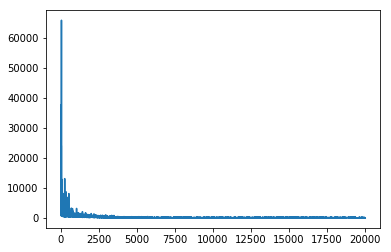

In [59]:
plt.plot(losses)

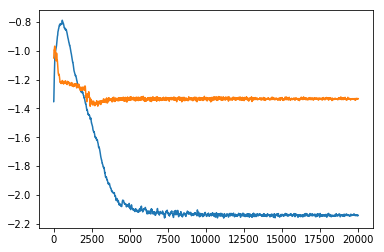

In [61]:
plt.plot(param_history['coord_scale_loc'].detach().numpy())

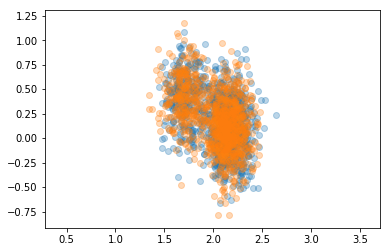

In [63]:
from tracepredictive import *

trace_pred = TracePredictive(model, svi, num_samples=1000).run(data[:,:500], hyperparameters)
random_idx = np.random.randint(1000)
predictive_dst_sample = [torch.unsqueeze(trace.nodes['obs']['value'][random_idx,:],dim=0) for trace in trace_pred.exec_traces]
predictive_dst_sample = torch.cat(predictive_dst_sample, dim=0)

plt.scatter(*data.detach().numpy().T,alpha=.3)
plt.scatter(*predictive_dst_sample.detach().numpy().T,alpha=.3);
plt.axis('equal');